In [48]:
import numpy as np
import math
from numpy import arange, sin, pi

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%matplotlib inline

In [209]:
class Scheduler:
    """
    Initialization
    """
    def __init__(self, pareto_a=14.5, pareto_m=1000, time_between_clients=11, c=1,
                 initial_clients_count=100, generated_clients_count=1000):
        
        # Initializing Pareto distribution parameters to obtain A values
        self.pareto_a = pareto_a
        self.pareto_m = pareto_m

        # Average time between client arrivals
        self.time_between_clients = time_between_clients

        # Calculating mean capacity value as r = cλA
        A_mean = (pareto_m * pareto_a / (pareto_a - 1))
        A_mean = A_mean * 0.4 + 10 * A_mean * 0.3 + 50 * A_mean * 0.2 + 125 * A_mean * 0.1

        time_between_clients_mean = time_between_clients
        time_between_clients_std = math.sqrt(time_between_clients)
        λ = 1 / (time_between_clients_mean)
        self.r = (λ * A_mean) * c
        
        self.initial_clients_count = initial_clients_count
        self.generated_clients_count = generated_clients_count

        # Creating lists for processed clients, clients who will come in system in the future, current queue
        self.processed_clients = []
        self.all_clients = []
        self.all_reg = []

        self.queue = []
        self.reg = []
        
        # Initializing time variable
        self.t = 0
    
    """
    Cleaning data from previous simulation
    """
    def clean(self):
        # Cleaning lists for processed clients, clients who will come in system in the future, current queue
        self.processed_clients = []
        self.all_clients = []
        self.all_reg = []

        self.queue = []
        self.reg = []
        # Zeroing time variable
        self.t = 0

    """
    Method for initial clients generation
    """
    def generate_initial_clients(self):
        # Generate 'initial_clients_count' clients
        for i in range(self.initial_clients_count):
            # Generate a random variable from Pareto distribution
            Ak = (np.random.pareto(self.pareto_a) + 1) * self.pareto_m
            # Choice a Ak with probability, that equals 0.4, 10Ak with probability, that equals 0.3
            # 50Ak with probability, that equals 0.2 or 125Ak with probability, that equals 0.1
            Ak = int(np.random.choice([Ak, 10 * Ak, 50 * Ak, 125 * Ak], p=[0.4, 0.3, 0.2, 0.1]))
            # Generate a random mean capacity
            rk_mean = int(np.random.uniform(self.r / math.sqrt(10), self.r * math.sqrt(10)))
            # Generate a random current information count
            Rk = int(np.random.uniform(0, Ak))
            Tk0 = 0
            # Appending client to queue
            client = [Tk0, Ak, Rk, rk_mean]
            reg_ = np.random.uniform(0, 20000)
            self.reg.append(reg_)
            self.queue.append(client)
            
    """
    Method for pseudo-real-time clients generation
    """
    def generate_clients(self):
        T0 = 0
        # Generate 'generated_clients_count' clients
        for i in range(self.generated_clients_count):
            # Generate a random variable from Pareto distribution
            Ak = (np.random.pareto(self.pareto_a) + 1) * self.pareto_m
            # Choice a Ak with probability, that equals 0.4, 10Ak with probability, that equals 0.3
            # 50Ak with probability, that equals 0.2 or 125Ak with probability, that equals 0.1
            Ak = int(np.random.choice([Ak, 10 * Ak, 50 * Ak, 125 * Ak], p=[0.4, 0.3, 0.2, 0.1]))
            # Generate a random mean capacity
            rk_mean = int(np.random.uniform(self.r / math.sqrt(10), self.r * math.sqrt(10)))
            # Generate a random generation time from Exponential distribution
            T0 += int(np.random.exponential(self.time_between_clients))
            Rk = 0
            # Appending client to list for clients who will come in system in the future
            client = [T0, Ak, Rk, rk_mean]
            reg_ = np.random.uniform(0, 20000)
            self.all_reg.append(reg_)
            self.all_clients.append(client)
    
    """
    Method, that returns index value for current client
    """
    def index_client(self, index_strategy, rk, Rk, rk_mean, Tk, Tk0):
        if index_strategy == "MaxC/I":
            return Tk0
        elif index_strategy == "PF":
            return rk * Tk / Rk
        elif index_strategy == "DAS":
            return rk / Rk
        elif index_strategy == "TAS":
            return rk / (Tk + 1e-20) 
        elif index_strategy == "T":
            c1 = 0.6 / math.log(13/7)
            return Rk / (  Tk + (Rk / (c1*rk_mean + 1e-20))  )
        elif index_strategy == "Random":
            return np.random.uniform(0, 1)
        elif index_strategy == "TK":
            return rk * Rk / (Tk + 1e-20)
        elif index_strategy == "T1":
            c1 = 0.6 / math.log(13/7)
            return Tk0 - Rk / (rk_mean*c1)
        elif index_strategy == "T2":
            c1 = 0.6 / math.log(13/7)
            return (Tk+Rk/(rk_mean*c1))*Rk/(rk_mean*c1)
        elif index_strategy == "T3":
            c1 = 0.6 / math.log(13/7)
            a = Tk - Rk / (c1*rk_mean)
            b = 1/(c1*rk_mean)
            return (Rk+1)*(Rk+1)*(b/(a*a)*math.log((Rk+1)/(Rk+a/b+1))+1/(a*(Rk+1)))
    
    """
    Generation random strategy from 'strategies_list' with probabilities 'probabilities_list'
    """
    def generate_random_strategy(self, strategies_list, probabilities_list):
        return np.random.choice(strategies_list, p=probabilities_list)
    
    """
    Appending client to current queue from list for clients who will come in system in the future
    """
    def add_user_to_queue(self):
        j = 0
        while ((j < len(self.all_clients)) and (self.all_clients[j][0] <= self.t)):
            j += 1
        self.queue += self.all_clients[:j]
        self.reg += self.all_reg[:j]
        self.all_clients[:j] = []
        self.all_reg[:j] = []
        
    """
    Calculating index values for every client in queue and getting argmax
    """
    def get_optimal_client(self, strategy):
        max_index = -1e20
        argmax_index = 0
        rk_argmax = 0
        for k in range(len(self.queue)):
            Tk0 = self.queue[k][0]
            reg_ = self.reg[k]
            Tk = self.t - Tk0
                
            rk_mean = ((sin(0.00005*pi*(self.t + reg_)) + 1) / 2 * (math.sqrt(10) - 1 / math.sqrt(10)) + 1 / math.sqrt(10)) * self.queue[k][3]
            rk_mean_ = sum([((sin(0.00005*pi*(self.t + reg_)) + 1) / 2 * (math.sqrt(10) - 1 / math.sqrt(10)) + 1 / math.sqrt(10)) * self.queue[k][3] for i in range(self.t - 9, self.t+1)]) / 10
    
            rk = int(np.random.uniform(rk_mean * 0.7, rk_mean * 1.3))
            Rk = self.queue[k][2] + 1e-10
                
            index_k = self.index_client(strategy, rk, Rk, rk_mean_, Tk, Tk0)
            if index_k > max_index :
                max_index = index_k
                argmax_index = k
                rk_argmax = rk
        return max_index, argmax_index, rk_argmax

    """
    Transfer of information to the clients
    """
    def update_client(self, argmax_index, rk_argmax):
        if len(self.queue) > 0:
            self.queue[argmax_index][2] += rk_argmax
            if self.queue[argmax_index][2] >= self.queue[argmax_index][1]:
                self.queue[argmax_index].append(self.t - self.queue[argmax_index][0])
                self.processed_clients.append(self.queue[argmax_index])
                del self.queue[argmax_index]
                del self.reg[argmax_index]

    """
    Main simulation method
    """
    def run_simulation(self, strategies_list, probabilities_list):
        history = []
        huawei_quality_metric = 0.
        
        # iterating, while all clients from list for clients who will come in system in the future
        # aren't appended to the queue 
        while len(self.all_clients) != 0:
            self.t += 1
            strategy = self.generate_random_strategy(strategies_list, probabilities_list)
            
            self.add_user_to_queue()
            max_index, argmax_index, rk_argmax = self.get_optimal_client(strategy)
            self.update_client(argmax_index, rk_argmax)
            
            # Appending current queue length to the 'history' list
            history.append(len(self.queue))
#             if self.t % 1000 == 0:
#                 print(self.reg[argmax_index])
#                 print("Queue length (t = ", self.t, "): ", len(self.queue), sep="")
        
        # Calculating ALPT
        
#         for i in range(len(self.processed_clients)):
#             huawei_quality_metric += self.processed_clients[i][1] / self.processed_clients[i][-1]
#         huawei_quality_metric /= len(self.processed_clients)
            
        # Calculating log-ALPT
        
        for i in range(len(self.processed_clients)):
            huawei_quality_metric += math.log(self.processed_clients[i][1] / (self.processed_clients[i][-1] + 1))
        huawei_quality_metric /= len(self.processed_clients)
        print("Mean queue size:", round(np.mean(history)))
        print("Time:", self.t / 60)

        # Calculating 10%-ALPT
        
#         huawei_quality_metric_list = []
#         for i in range(len(self.processed_clients)):
#             huawei_quality_metric_list.append(math.log(self.processed_clients[i][1] / self.processed_clients[i][-1]))
#         huawei_quality_metric_list.sort()
#         huawei_quality_metric = huawei_quality_metric_list[:abs(len(self.processed_clients) * 0.1)] / abs(len(self.processed_clients) * 0.1)
        
        return history, huawei_quality_metric

In [211]:
print("–––––––––––––––––––––––––––––––––––––––")
for critery in ["DAS", "MaxC/I", "TAS", "TK", "T"]:
    metrics = []
    for i in range(1):
        scheduler = Scheduler(c=1, generated_clients_count=10000)
        scheduler.generate_initial_clients()
        scheduler.generate_clients()
        history, metric = scheduler.run_simulation([critery], [1])
        metrics.append(metric)
    print(critery, ":", round(sum(metrics)/len(metrics), 2), end="\n–––––––––––––––––––––––––––––––––––––––\n")

–––––––––––––––––––––––––––––––––––––––
Mean queue size: 20.0
Time: 1753.1333333333334
DAS : 7.37
–––––––––––––––––––––––––––––––––––––––
Mean queue size: 56.0
Time: 1741.6666666666667
MaxC/I : 7.29
–––––––––––––––––––––––––––––––––––––––
Mean queue size: 29.0
Time: 1721.1333333333334
TAS : 7.38
–––––––––––––––––––––––––––––––––––––––
Mean queue size: 57.0
Time: 1755.9333333333334
TK : 7.09
–––––––––––––––––––––––––––––––––––––––
Mean queue size: 74.0
Time: 1751.95
T : 7.02
–––––––––––––––––––––––––––––––––––––––


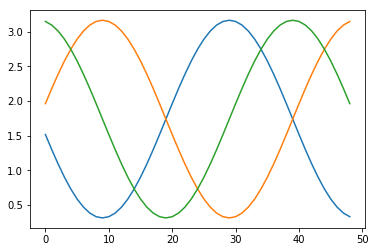

In [198]:
x = np.array(list(range(1000, 50000, 1000)))
reg_ = 20000
plt.plot((sin(0.00005*pi*(x + reg_)) + 1) / 2 * (math.sqrt(10) - 1 / math.sqrt(10)) + 1 / math.sqrt(10))
reg_ = 0
plt.plot((sin(0.00005*pi*(x + reg_)) + 1) / 2 * (math.sqrt(10) - 1 / math.sqrt(10)) + 1 / math.sqrt(10))
reg_ = 10000
plt.plot((sin(0.00005*pi*(x + reg_)) + 1) / 2 * (math.sqrt(10) - 1 / math.sqrt(10)) + 1 / math.sqrt(10))

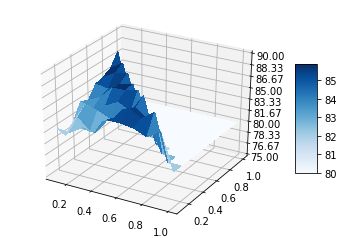

In [138]:
scheduler = Scheduler()
scheduler.generate_initial_clients()
scheduler.generate_clients()
strategies = ["IBM", "T", "TAS"]

X, Y, z, z_high, z_low = [], [], [], [], []
for i in range(10):
    x = (i + 1) / 10
    X.append(x)
    Y = []
    for h in range(9-i):
        y = (h + 1) / 10
        Y.append(y)
        metrics = []
        for j in range(5):
            history, metric = scheduler.run_simulation(strategies, [x, y, 1-(x+y)])
            scheduler.clean()
            scheduler.generate_initial_clients()
            scheduler.generate_clients()
            metrics.append(metric)
        metrics = np.array(metrics)

        metric_mean = np.mean(metrics)
        metric_high = np.mean(metrics) + np.std(metrics)
        metric_low = np.mean(metrics) - np.std(metrics)

        z.append(metric_mean)
        z_high.append(metric_high)
        z_low.append(metric_low)
    for h in range(4-i, 5):
        y = (h + 1) / 10
        Y.append(y)
        z.append(80)
        z_high.append(0)
        z_low.append(0)
Y = np.array(Y) + 0.5
x = 0.1
y = 0.1
history, metric = scheduler.run_simulation(strategies, [x, y, 1-(x+y)])
scheduler.clean()
scheduler.generate_initial_clients()
scheduler.generate_clients()

X_, Y_ = np.meshgrid(X, Y)
np.max(np.array(z)), np.matrix.argmax(np.matrix(np.array(z).reshape(10, 10)))

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X_, Y_, np.array(z).reshape(10, 10), cmap=cm.Blues,
                       linewidth=0, antialiased=False)

ax.set_zlim(75, 90)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)